# MAST30034 Applied Data Science Project 1 Modelling and Correlation Analysis

Student Name: Haonan Zhong

Student ID: 867492

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy import stats

In [3]:
data = pd.read_feather('../preprocessed_data/cleaned_2018.feather')

In [4]:
data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'total_amount', 'season', 'date', 'time',
       'weekday', 'duration', 'day_type', 'tip_percent', 'time_desc', 'AWND',
       'PRCP', 'SNOW', 'SNWD', 'TAVG', 'PUborough', 'DOborough'],
      dtype='object')

# Correlation

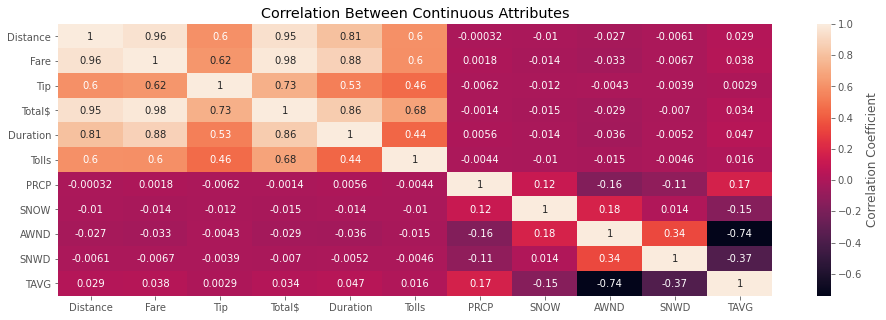

In [5]:
col = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'duration', 'tolls_amount', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'TAVG']
label = ['Distance', 'Fare', 'Tip', 'Total$', 'Duration', 'Tolls', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'TAVG']

# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 5))
corr_matrix = data[col].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

# Sampling data for modelling

In [6]:
# keep only card payment, since tip on cash payment is not recorded

sample = data[data['payment_type'] == 1].sample(frac=0.05, replace=True, random_state=30034).reset_index(drop=True)

# Initial fit Linear Regression

In [6]:
COL = ['passenger_count', 'fare_amount', 'tip_amount', 'tolls_amount', 
       'season', 'day_type', 'time_desc', 'PUborough', 'DOborough']
sample_filtered = sample.loc[:, COL].reset_index(drop=True)

In [7]:
# Split data to train and test
y = sample_filtered['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(sample_filtered, y, test_size=0.3, random_state=0)

In [8]:
# Scale the continuous attributes
xCOLS = ['fare_amount', 'tolls_amount']

scaler = StandardScaler()
X_train[xCOLS] = scaler.fit_transform(X_train[xCOLS])
X_test[xCOLS] = scaler.transform(X_test[xCOLS])

In [9]:
# Baseline model which contains only the intercept

baseline = ols(formula='tip_amount ~ 1', data=X_train).fit()
print(baseline.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 14 Aug 2021   Prob (F-statistic):                nan
Time:                        23:50:15   Log-Likelihood:            -1.7546e+06
No. Observations:              771971   AIC:                         3.509e+06
Df Residuals:                  771970   BIC:                         3.509e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5888      0.003    968.316      0.0

In [10]:
base_train_pred = baseline.predict(X_train)
base_test_pred = baseline.predict(X_test)
train_rmse = mean_squared_error(y_train, base_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, base_test_pred, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 2.349005604995997
Test RMSE: 2.353694615557384


In [11]:
# fit the model
full_model = ols(formula='tip_amount ~ C(passenger_count) + fare_amount + tolls_amount + season + time_desc + day_type + PUborough + DOborough', data=X_train).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                 6.956e+04
Date:                Sat, 14 Aug 2021   Prob (F-statistic):               0.00
Time:                        23:50:26   Log-Likelihood:            -1.3102e+06
No. Observations:              771971   AIC:                         2.620e+06
Df Residuals:                  771946   BIC:                         2.621e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [12]:
# predict and evaluate
full_train_pred = full_model.predict(X_train)
full_test_pred = full_model.predict(X_test)
train_rmse = mean_squared_error(y_train, full_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, full_test_pred, squared=False)
train_r2 = r2_score(y_train, full_train_pred)
test_r2 = r2_score(y_test, full_test_pred)

print("Full model")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2", train_r2)
print("Test R2", test_r2)

Full model
Train RMSE: 1.3208674584294686
Test RMSE: 1.3205778412904983
Train R2 0.683808365563723
Test R2 0.6852050276806394


# Diagnostic plots

In [ ]:
sns.residplot(full_test_pred,y_test,lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')
plt.show()

In [ ]:
residuals = y_test - full_test_pred

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

In [ ]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(full_test_pred, model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")
plt.show()

# Gradient Boost Regression

In [19]:
# convert categorical data to dummy variable

sample_filtered = pd.get_dummies(sample_filtered, drop_first=True)

In [20]:
# train test split the sampled data

y = sample_filtered['tip_amount']
sample_filtered = sample_filtered.drop(['tip_amount'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(sample_filtered, y, test_size=0.3, random_state=0)

In [21]:
# fit the model
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [22]:
reg.feature_importances_

array([9.56421044e-01, 2.56532234e-02, 9.82139692e-05, 0.00000000e+00,
       9.30541812e-04, 4.78756329e-05, 3.21579095e-04, 3.81668702e-04,
       7.99758087e-06, 3.59582681e-04, 2.53509098e-03, 0.00000000e+00,
       1.38596878e-03, 2.04882893e-03, 1.03412431e-04, 8.69011918e-04,
       1.76500220e-04, 9.77407246e-04, 4.44653982e-03, 5.52199248e-04,
       9.92292576e-04, 6.94198855e-05, 1.60057609e-03, 2.10252795e-05])

In [23]:
# predict and evaluate

gbr_train_pred = reg.predict(X_train)
gbr_test_pred = reg.predict(X_test)
train_rmse = mean_squared_error(y_train, gbr_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, gbr_test_pred, squared=False)
train_r2 = r2_score(y_train, gbr_train_pred)
test_r2 = r2_score(y_test, gbr_test_pred)

print("Gradient Boost Regression")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2", train_r2)
print("Test R2", test_r2)

Gradient Boost Regression
Train RMSE: 1.3002747088427646
Test RMSE: 1.309557881525714
Train R2 0.6935905716805757
Test R2 0.6904369097350149
